# Initialization

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time
import datetime as dt

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

sys.path.append("C:/Users/TUD210595/Documents/LOCAL_Qcodes/scripts")
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

To modify list of instruments, eddit file
"C:\Users\TUD210595\Documents\LOCAL_Qcodes\scripts\init_VectorJanis.py"

In [2]:
fridge_name = 'VectorJanis'
%run C:\Users\TUD210595\Documents\LOCAL_Qcodes\scripts\init_fridge.py {fridge_name}

Connected to: Cryomagnetics LM-500 (serial:4563, firmware:2.19) in 0.21s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04438025, firmware:1.0.04b) in 0.02s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04441805, firmware:1.0.04b) in 0.02s
Connected to: Stanford_Research_Systems SR830 (serial:s/n43606, firmware:ver1.07) in 0.05s
Connected to: Stanford_Research_Systems SR830 (serial:s/n43275, firmware:ver1.07) in 0.05s
Connected to: LSCI 340 (serial:342554, firmware:061407) in 0.04s
Connected to: Cryomagnetics 4G (serial:4559, firmware:1.24,259) in 0.12s
Initialized IVVI-rack in 0.04s


Here are all the instruments we have:

In [3]:
station.components

{'level_meter': <Model_LM500: level_meter>,
 'keithley_1': <Keithley_6500: keithley_1>,
 'keithley_2': <Keithley_6500: keithley_2>,
 'lockin_1': <SR830: lockin_1>,
 'lockin_2': <SR830: lockin_2>,
 'lakeshore': <Model_340: lakeshore>,
 'cryomag': <Model_4G: cryomag>,
 'ivvi': <IVVI: ivvi>}

Zero dacs and lockin

In [4]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

## DAC rates

Change the dac rate (same idea as with qtlab, but two commands are used)

In [ ]:
ivvi.dac1.step = 50
ivvi.dac1.inter_delay = 0.05
ivvi.dac2.step = 50
ivvi.dac2.inter_delay = 0.05
ivvi.dac3.step = 4
ivvi.dac3.inter_delay = 0.05

## Database initialisation

Next, we create a qcodes database, or we can use the existing one

In [6]:
#useful if you want to name database with creation date
date = str(dt.date.today())
db_path = "C:/Users/TUD210595/Documents/LOCAL_DATA/AlbertoBas"
initialise_or_create_database_at(db_path + "/" + "M157B.db" )

# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [ ]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters. Run ONLY ONCE!

In [ ]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1000 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
# Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
# station.add_component(Gain_L2)

## IVVI rack parameters - UPDATE here DURING measuerements

Also can be coppied to execute later

In [ ]:
Irange.set(10e-6)
Vrange.set(1e-3)
TGrange.set(15)
Gain_K1.set(1e2)
Gain_K2.set(1e2)
Gain_L1.set(Gain_K1())
# Gain_L2.set(Gain_K2())

#ac_amplitude = 20e-9  # Ampere
#ac_amplitude_V = ac_amplitude*100/Irange()  # value in V to read on the lockin amplitude display
#lockin_1.amplitude(ac_amplitude_V)
#lockin_1.sensitivity(0.002)
#lockin_1.frequency(18.7)
#lockin_1.phase(180)

#lockin_1.time_constant(0.3) #integration time in s

#division parameters are updated automatically

## DC parameters - assigning devices. RUN ONLY ONCE!
Check that devicies are correct!

In [ ]:
appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(ivvi.dac2, division = Vrange_division, name = 'appl_voltage', unit = 'V')
appl_TG = ScaledParameter(ivvi.dac3, division = TGrange_division, name = 'appl_TG', unit = 'V')

meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
meas_voltage_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')
# meas_voltage_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_voltage_K3', unit = 'V')
meas_leakage = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

meas_current_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
meas_current_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')
# meas_current_K3 = ScaledParameter(keithley_3.amplitude, division = Gain_K3, name = 'meas_current_K3', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
station.add_component(appl_TG)
station.add_component(meas_voltage_K1)
station.add_component(meas_voltage_K2)
# station.add_component(meas_voltage_K3)
station.add_component(meas_leakage)
station.add_component(meas_current_K1)
station.add_component(meas_current_K2)
# station.add_component(meas_current_K3)

### Additional DC parameters - RUN ONLY ONCE

In [ ]:
meas_voltage_K1_zeroA = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1_zeroA', unit = 'V')
station.add_component(meas_voltage_K1_zeroA)

Reasining devices seems to be missing in public methods of ScaledParameter class... But you can try:

In [ ]:
ivvi.dac1()

## AC parameters - RUN ONLY ONCE

In [ ]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(lockin_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')

meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)

### Additional AC parameters - RUN ONLY ONCE

In [ ]:
## Y-Component of lockin
meas_voltage_AC_L1_Y = ScaledParameter(lockin_1.Y, division = Gain_L1, name = 'meas_voltage_Lockin1_Y', unit = 'V')

## R-Component of lockin
meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_Lockin1_R', unit = 'V')

## Phase component of lockin
meas_voltage_AC_L1_P = ScaledParameter(lockin_1.P, division = 1, name = 'meas_voltage_Lockin1_P', unit = 'DEG')
station.add_component(meas_voltage_AC_L1_Y)
station.add_component(meas_voltage_AC_L1_R)
station.add_component(meas_voltage_AC_L1_P)

## Another useful example: magnet using dac (Janis)

>2231.2 G per A => 0.22312 T per A<br>
I source 10mA per V => 1e-5 A per 1mV<br>
result: 0.22312 T/A * 1e-5 A/mV

In [ ]:
#magnetic_field = ScaledParameter(ivvi.dac3, gain = 0.22312e-5, name = 'magnetic_field_dac', unit = 'T')
#station.add_component(magnetic_field)

# Fidge controll. Condensing. Magnet

In [ ]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

In [ ]:
lakeshore.output_1.output_range('off')
#lakeshore.output_1.setpoint(45.0)
# lakeshore.output_1.input_channel('A')
#lakeshore.output_1.output_range('2.5W')

In [ ]:
print('Temps: A= {:.2f}, B = {:.4f}, C ={:.4f}'.format(lakeshore.A.temperature(), lakeshore.B.temperature(), lakeshore.C.temperature()) )

In [ ]:
level_meter.print_readable_snapshot(update=True)

In [ ]:
# level_meter.sample_mode('Continuous')
# level_meter.sample_mode('Sample/Hold')

In [ ]:
while True:
    print('A= {:.2f}, B = {:.4f}, C ={:.4f}, power = {:.2f}'.format(lakeshore.A.temperature(), lakeshore.B.temperature(), lakeshore.C.temperature(), lakeshore.output_1.output()), end = '\r')
    sleep(1)

In [ ]:
while True:
    print('He Level = {:.2f}'.format(level_meter.lastval()), end = '\r')
    sleep(1)

In [ ]:
cryomag.print_readable_snapshot(update = True)

In [ ]:
cryomag.channel_B.ask('IMAG?')

In [ ]:
cryomag.channel_B.ask('IOUT?')

In [ ]:
cryomag.channel_B.ask('IMAG?')

In [ ]:
# cryomag.channel_B.write('IMAG 0.0')

In [ ]:
cryomag.channel_B.ask('IOUT?')

In [ ]:
cryomag.channel_B.write('QRESET')

In [ ]:
cryomag.channel_B.write('REMOTE')

In [ ]:
cryomag.channel_B.ask('*STB?')

In [ ]:
cryomag.channel_A.field()

In [ ]:
cryomag.channel_B.field(0)

In [ ]:
cryomag.channel_A.heater('off')
cryomag.channel_B.heater('off')

In [ ]:
cryomag.channel_A.write('SWEEP ZERO')
cryomag.channel_B.write('SWEEP ZERO')

In [ ]:
print('field 4T magnet = {:.4f} T'.format(cryomag.channel_A.field()) )
print('tolerance for set field 4T magnet = {:.1f} mT'.format(cryomag.channel_A.tolerance()) )

print('field 9T magnet = {:.4f} T'.format(cryomag.channel_B.field()) )
print('tolerance for set field 9T magnet = {:.1f} mT'.format(cryomag.channel_B.tolerance()) )

# Standard sweeps: setting parameter

## 1D sweeps

In [ ]:
# current_AC(1e-6)
exp = qc.new_experiment('IV-curve', sample_name='Sn_film_M111B')
dataid = do1d(appl_current, -1e-6, 1e-6, 100, 0.2, meas_voltage_K1, meas_voltage_AC_L1)
#sweep current from -10uA to 10uA 100 points with 0.2sec delay
#records voltage on keithley and lockin
ivvi.set_dacs_zero()

In [ ]:
ivvi.set_dacs_zero()


### Plotting

In [ ]:
plot_by_id(dataid)

### Plotting later using list of experiments

In [ ]:
qc.experiments()

In [ ]:
dataset = qc.load_by_id(1)
plot_dataset(dataset)

## 2D sweeps

In [ ]:
exp = qc.new_experiment('IV-curve_vs_dac5', sample_name='simulator_100_Ohm')
dataid = do2d(ivvi.dac5, -1, 1, 3, 5, current, -10e-6, 10e-6, 100, 0.2, voltage_DC)
#sweep current from -10uA to 10uA 100 points with 0.2sec delay
#records voltage on keithley and lockin
ivvi.set_dacs_zero()

In [ ]:
plot_by_id(dataid)

In [ ]:
cmap = plt.get_cmap('hot')
plot_by_id(dataid, cmap = cmap)
plt.savefig('../plots/iv_vs_dac5.pdf')

## What if you want to measure vs magnetic field? Use same functions!

In [ ]:
#exp = qc.load_or_create_experiment(experiment_name='IV-curve_vs_Bz', sample_name='simulator_100_Ohm')
#dataid = do2d(cryomag.channel_A.field, 0, 0.001, 10, 1, current, -10e-6, 10e-6, 100, 0.2, voltage_DC)
#ivvi.set_dacs_zero()

# Standard sweeps: measuring without setting value

## Measured values versus non-setable parameter

In [ ]:
time = ElapsedTimeParameter('time')

def time_limit(time, measured_values):
    return time() > 6

In [ ]:
exp = qc.new_experiment('V_vs_time', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
time.reset_clock()
dataid = measure_until(time, time_limit, 1, voltage_DC, voltage_AC)

In [ ]:
plot_by_id(dataid)

## Useful for temperature scans and magnet sweeps:

In [ ]:
def temp_limit(temp, measured_values):
    return temp() < 0.4

exp = qc.new_experiment('V_vs_temp_CD', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
dataid = measure_until(lakeshore.A.temperature, temp_limit, 1, voltage_DC, voltage_AC)

In [ ]:
end_field = 0.0
tolerance = 0.001
    
def field_reached(field, measured_values):
    return np.abs( field()-end_field ) < tolerance

exp = qc.new_experiment('V_vs_field', sample_name='simulator_10_kOhm')

magnet_z.ramp_rate(0.004)#T/sec
magnet_z.set_field(end_field,block=False)
#for Sg1: x_target(value), magnet.start_sweep()
#measure: magnet.x_measure()
dataid = measure_until(magnet_z.field, field_reached, 1, voltage_DC, voltage_AC)

### Exit based on measured value

In [ ]:
def voltage_limit(time, measured_values):
    return measured_values[0].get() > -0.94e-3

exp = qc.new_experiment('V_vs_time', sample_name='simulator_100_Ohm')
current(10e-6)
current_AC(1e-6)
time = ElapsedTimeParameter('time')
time.reset_clock()
dataid = measure_until(time, voltage_limit, 1, voltage_DC, voltage_AC)

In [ ]:
plot_by_id(dataid)

## 1D scan vs non-setable parameter

In [ ]:
time = ElapsedTimeParameter('time')

#note that here exit_condition takes two independent parameters and only then measured parameters
def time_limit(time, current, measured_values):
    return time() > 30

exp = qc.new_experiment('IV_vs_time', sample_name='simulator_100_Ohm')
current_AC(0.04e-6)
time.reset_clock()
dataid = do1d_until(time, time_limit, 1, current, -10e-6, 10e-6, 100, 0.2, voltage_DC)

In [ ]:
cmap = plt.get_cmap('hot')
plot_by_id(dataid, cmap = cmap)

# Custom sweeps

## Setting the temperature

In [ ]:
exp = qc.load_or_create_experiment(experiment_name='V-vs-set_temp', sample_name='sample_pd12')
lakeshore.output_1.output_range('0.5W')

start = 5
stop = 12
num_points = 30

#Register independent parameters
meas = Measurement()
meas.register_parameter(lakeshore.A.temperature)

#Register dependent parametrs
param_meas = [voltage_DC, voltage_AC]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(lakeshore.A.temperature,))
    output.append([parameter, None])

#Add action at the end
meas.add_after_run(lakeshore.output_1.setpoint, (0.0))
meas.add_after_run(lakeshore.output_1.setpoint, ('off'))
meas.add_after_run(ivvi.set_dacs_zero)

#Start measuremnts
with meas.run() as datasaver:
    for set_point in np.linspace(start, stop, num_points):
        #set temperature and wait
        lakeshore.output_1.setpoint(set_point)
        sleep(10)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((lakeshore.A.temperature, lakeshore.A.temperature()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

## Gate sweep controlling the leakage

In [ ]:
exp = qc.new_experiment('V_vs_Vgate', sample_name='TL1_1-14')
appl_voltage(1e-3)

start_gate = 0.0
stop_gate = -0.5
num_points = 200
leak_threshold = 1e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_TG)
appl_TG.post_delay = 0.05

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_TG,))
    output.append([parameter, None])

#Add action at the end
meas.add_after_run(ivvi.set_dacs_zero, ())

appl_TG(start_gate)
sleep(2)

#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)):
        appl_TG(set_point)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            break
        sleep(0.1)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((appl_TG, appl_TG()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting
plot_by_id(dataid)

# Snapshots

In [ ]:
dataset = qc.load_by_id(1)
dataset.snapshot['station']

In [ ]:
dataset.snapshot['station']['parameters']['current_AC']

In [ ]:
dataset.snapshot['station']['instruments']['ivvi']

In [ ]:
pprint(diff_param_values(qc.load_by_id(1).snapshot, qc.load_by_id(2).snapshot).changed)

# AlbertoBas Measurements

## Voltage vs Temperature w/ constant DC current

In [ ]:
ivvi.set_dacs_zero()

In [ ]:
## Apply a constant current in Ampere
appl_current(10e-6)
## Set exit condition based on registered temperature
def temp_limit(temp, measured_values):
    return temp() > 300

exp = qc.new_experiment('V_vs_Temp', sample_name='Sn_film_M111_20uA_Tto300')

## Set a delay in seconds
delay = 0.5
    
## Measure 'meas_voltage_K1' against 'lakeshore.C.temperature' until temp_limit is satisfied
dataid = measure_until(lakeshore.B.temperature, temp_limit, delay,meas_voltage_K1, meas_voltage_AC_L1,meas_voltage_AC_L1_Y,meas_voltage_AC_L1_R,meas_voltage_AC_L1_P, lakeshore.C.temperature)
ivvi.set_dacs_zero()


In [ ]:
plot_by_id(dataid)

## Voltage vs Temperature w/ removing zero current bias

In [ ]:
## Same experiment as in (8.1)
## Zero-current bias voltage is subtracted from measured voltage


## Set time between zero-current checks in seconds
timer_z = ElapsedTimeParameter('z_time')
zero_time = 10

## get initial zero current bias:
ivvi.set_dacs_zero()
sleep(0.1)
zero_current_bias = meas_voltage_K1.get()
print("Zero current bias : {}".format(zero_current_bias))

## set initial current in Amperes
appl_current.set(10e-6)

## initialize experiment with description and sample name
exp = qc.new_experiment('V_vs_Temp', sample_name='Sn_film_M157B__10uA')

## set exit condition function based on registered temperature
def exit_condition(temp, measured_values):
    return temp() < 2.5

## Set delay between measurements (note: also affects checking if the reversal_time/zero_time has passed)
delay = 0.5

## Register independent parameters
param_ind = lakeshore.B.temperature
meas = Measurement()
meas.register_parameter(param_ind)
output = []

## Register dependent parameters
param_meas = [meas_voltage_K1, meas_voltage_AC_L1,meas_voltage_AC_L1_Y,meas_voltage_AC_L1_R,meas_voltage_AC_L1_P, meas_voltage_K1_zeroA]
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(param_ind,))
    output.append([parameter, None])

## Collect data until exit_condition is met
with meas.run() as datasaver:
    timer_z.reset_clock()
    while not exit_condition(param_ind, param_meas):
        ## check times
        if timer_z() > zero_time:
            prev_current = appl_current()
            appl_current.set(0)
            ## Sleep for 0.5 seconds and get the zero current bias
            sleep(0.25)
            zero_current_bias = meas_voltage_K1.get()
            #print("Zero current bias at T = {}K  : {}".format(param_ind.get(),zero_current_bias))
            ## Set current back to previous value
            appl_current.set(prev_current)
            sleep(0.25)
            timer_z.reset_clock()
            
        for i, parameter in enumerate(param_meas):
            if(parameter != meas_voltage_K1_zeroA):
                output[i][1] = parameter.get() 
            else:
                output[i][1] = zero_current_bias
            
        datasaver.add_result((param_ind, param_ind.get()),*output)
        sleep(delay)

dataid = datasaver.run_id
ivvi.set_dacs_zero()


## Voltage vs Magnetic Field w/ constant DC current

In [ ]:
## get initial zero current bias:
ivvi.set_dacs_zero()
zero_current_bias = meas_voltage_K1.get()
print("Initial voltage for 0 applied current: {}".format(zero_current_bias))
## Apply a constant current in Ampere
appl_current.set(10e-6)
delay = 5

exp = qc.new_experiment('V_vs_field_x', sample_name='Sn_film_M157_10uA__SweepingBx')
dataid = do1d(cryomag.channel_A.field, 0, 0.12, 400, delay,  meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_Y,meas_voltage_AC_L1_P, lakeshore.C.temperature)
ivvi.set_dacs_zero()

## Voltage vs Magnetic Field w/ recording zero current bias

In [ ]:
## Apply a constant current in Ampere
appl_current.set(0)
## get the zero current bias
zero_current_bias = meas_voltage_K1.get()
print("Initial bias: {}V".format(zero_current_bias))
appl_current.set(10e-6)
exp = qc.new_experiment('V_vs_field', sample_name='Sn_film_M144_10uA_0.1T-0.5T')

## Set a delay in seconds
delay = 5

## Register independent parameter
param_set = cryomag.channel_A.field
meas = Measurement()
meas.register_parameter(param_set)  
output = []

## Set start, stop, num points and delay
start = 0
stop = 0.1
num_point = 100  
param_set.post_delay = delay

## Register dependent parameters
param_meas = [meas_voltage_K1, meas_voltage_AC_L1, lakeshore.C.temperature]
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(param_set,))
    output.append([parameter, None])

with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start, stop, num_points)):
        param_set.set(set_point)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((param_set, set_point),
                             *output)
        
        ## Get the zero current bias 
        prev_current = appl_current()
        appl_current.set(0)
        ## Sleep for 0.2 seconds and get the zero current bias
        sleep(0.2)
        zero_current_bias = meas_voltage_K1.get()
        print("Zero current bias at B = {}T  : {}".format(set_point,zero_current_bias))
        ## Set current back to previous value
        appl_current.set(prev_current)
        sleep(0.2)
        
dataid = datasaver.run_id 


In [ ]:
ivvi.set_dacs_zero()

## Voltage vs Magnetic Field w/ Do1D forward+backward

In [ ]:
cryomag.channel_A.field.set(0.08)
sleep(50)

exp = qc.new_experiment('V_vs_field_x', sample_name='Sn_film_M111_0uA_Bx__phase')
param   _set = cryomag.channel_A.field
start = 0.08
stop = 0.02
num_points = 120
delay = 3
param_meas = [meas_voltage_AC_L1,meas_voltage_AC_L1_Y,meas_voltage_AC_L1_R,meas_voltage_AC_L1_P, lakeshore.C.temperature]

meas = Measurement()
meas.register_parameter(param_set)  # register the first independent parameter
output = []
param_set.post_delay = delay

for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(param_set,))
    output.append([parameter, None])

with meas.run() as datasaver:
    forwards = np.linspace(start, stop, num_points)
    backwards = np.linspace(stop, start, num_points)
    setpoints = np.append(forwards,backwards)
    
    for set_point in tqdm(setpoints):
        param_set.set(set_point)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((param_set, set_point),*output)
dataid = datasaver.run_id  # convenient to have for plotting


In [3]:
from qcodes import load_or_create_experiment

In [4]:
from qcodes.dataset.experiment_container import load_experiment

Text(0.5, 0, 'Temperature [K]')

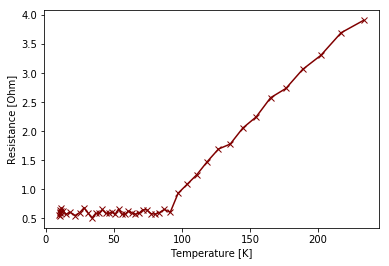

In [210]:
exp = load_experiment(19)
dataset = exp.data_set(1)
volt = dataset.get_parameter_data('meas_voltage_K1')
volt2 = dataset.get_parameter_data('meas_voltage_K1_zeroA')

volt_data = volt.get('meas_voltage_K1').get('meas_voltage_K1')
volt_data_zero  = volt2.get('meas_voltage_K1_zeroA').get('meas_voltage_K1_zeroA')
temp = volt.get('meas_voltage_K1').get('lakeshore_B_temperature')


end = 20000
interv = 400
resistance = (volt_data[:end:interv] - volt_data_zero[:end:interv])/(10**-6)
plt.plot(temp[:end:interv], resistance, marker = 'x', color = 'maroon')
plt.ylabel('Resistance [Ohm]')
plt.xlabel('Temperature [K]')
#volt_zero = dataset.get_parameter_data('meas_voltage_K1_zeroA')

In [8]:
     
exp = load_experiment(19)
dataset = exp.data_set(1)
print(dataset)

results #18@C:\Users\TUD210595\Documents\LOCAL_DATA\AlbertoBas\M157B.db
-----------------------------------------------------------------------
lakeshore_B_temperature - numeric
meas_voltage_K1 - numeric
meas_voltage_Lockin1 - numeric
meas_voltage_Lockin1_Y - numeric
meas_voltage_Lockin1_R - numeric
meas_voltage_Lockin1_P - numeric
meas_voltage_K1_zeroA - numeric


In [9]:
volt = dataset.get_parameter_data('meas_voltage_K1')
print(volt)


{'meas_voltage_K1': {'meas_voltage_K1': array([ -3.20480400e-05,  -3.21024200e-05,  -3.20644900e-05, ...,
        -6.17527800e-06,  -6.17087500e-06,  -6.16256600e-06]), 'lakeshore_B_temperature': array([ 233.722,  233.683,  233.643, ...,   44.047,   44.048,   44.048])}}


In [10]:
volt_data = volt.get('meas_voltage_K1').get('meas_voltage_K1')
print(volt_data)


[ -3.20480400e-05  -3.21024200e-05  -3.20644900e-05 ...,  -6.17527800e-06
  -6.17087500e-06  -6.16256600e-06]


286.543


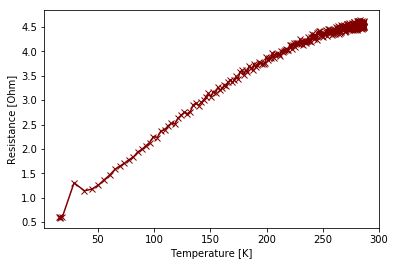

In [228]:
exp = load_experiment(45)
dataset = exp.data_set(1)
volt = dataset.get_parameter_data('meas_voltage_K1')
volt2 = dataset.get_parameter_data('meas_voltage_K1_zeroA')

volt_data = volt.get('meas_voltage_K1').get('meas_voltage_K1')
volt_data_zero  = volt2.get('meas_voltage_K1_zeroA').get('meas_voltage_K1_zeroA')
temp = volt.get('meas_voltage_K1').get('lakeshore_B_temperature')
end = 15000
interv = 50
resistance = (volt_data[:end:interv] - volt_data_zero[:end:interv])/(10*10**-6)
plt.plot(temp[:end:interv], resistance, color = 'maroon', marker = 'x')
plt.ylabel('Resistance [Ohm]')
plt.xlabel('Temperature [K]')
#volt_zero = dataset.get_parameter_data('meas_voltage_K1_zeroA')
print(temp[end])

In [154]:
ivvi.set_dacs_zero()